# Emotion Classification - CNN Model

Importing libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import numpy as np
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


- Creating model

In [ ]:
def create_emotion_cnn(input_shape=(48, 48, 1), num_classes=7):
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
  
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
 
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
 
        layers.Flatten(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [ ]:
def load_emotion_data(csv_path, data_dir, target_size=(48, 48), grayscale=False):
    df = pd.read_csv(csv_path)
    
    images = []
    labels = []
    
    print(f"Loading {len(df)} images...")
    failed_count = 0
    
    for idx, row in df.iterrows():
        try:
            img_path = f"{data_dir}/{row['path']}"
            
            if grayscale:
                img = Image.open(img_path).convert('L')  # Grayscale
            else:
                img = Image.open(img_path).convert('RGB')
                
            img = img.resize(target_size, Image.LANCZOS)  # Better resampling
            img_array = np.array(img, dtype='float32')
   
            img_array = img_array / 255.0

            if grayscale and len(img_array.shape) == 2:
                img_array = np.expand_dims(img_array, axis=-1)
            
            images.append(img_array)
            labels.append(row['label'])
            
            if (idx + 1) % 1000 == 0:
                print(f"Loaded {idx + 1}/{len(df)} images")
                
        except Exception as e:
            failed_count += 1
            if failed_count <= 5:  # Print first 5 errors
                print(f"Error loading {row['path']}: {e}")
            continue
    
    print(f"Successfully loaded {len(images)} images ({failed_count} failed)")
    return np.array(images), np.array(labels)


In [ ]:
def create_data_generators(X_train, y_train, X_val, y_val, batch_size=32):
  
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        horizontal_flip=True,
        zoom_range=0.15,
        shear_range=0.1,
        fill_mode='nearest'
    )
    
  
    val_datagen = ImageDataGenerator()
    
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=batch_size,
        shuffle=True
    )
    
    val_generator = val_datagen.flow(
        X_val, y_val,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_generator, val_generator

In [ ]:
def get_callbacks(model_name='best_model.keras'):
    
    return [
        ModelCheckpoint(
            model_name,
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]

In [ ]:
def train_emotion_model(approach='custom', batch_size=32):
    
    if approach == 'custom':
        target_size = (48, 48)
        grayscale = True
        input_shape = (48, 48, 1)
    
    

    print(f"Loading data for {approach} approach...")
    print(f"Target size: {target_size}, Grayscale: {grayscale}")
    
    X, y = load_emotion_data(
        './data_emotion/data (1).csv',
        './data_emotion',
        target_size=target_size,
        grayscale=grayscale
    )

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    num_classes = len(le.classes_)
    
    print(f"\nClasses: {le.classes_}")
    print(f"Number of classes: {num_classes}")
    print(f"Total samples: {len(X)}")
    print(f"Image shape: {X[0].shape}")
    
  
    unique, counts = np.unique(y_encoded, return_counts=True)
    print("\nClass distribution:")
    for cls, count in zip(le.classes_, counts):
        print(f"  {cls}: {count}")
    

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=0.15,
        random_state=42,
        stratify=y_train
    )
    
    print(f"\nData split:")
    print(f"  Train: {len(X_train)}")
    print(f"  Val: {len(X_val)}")
    print(f"  Test: {len(X_test)}")
    
    class_weights = {}
    total = len(y_train)
    for i in range(num_classes):
        count = np.sum(y_train == i)
        class_weights[i] = total / (num_classes * count)
    
    print(f"\nClass weights: {class_weights}")
    
    train_gen, val_gen = create_data_generators(
        X_train, y_train,
        X_val, y_val,
        batch_size=batch_size
    )
    
    if approach == 'custom':
        print("\n" + "="*60)
        print("Using Custom CNN approach (RECOMMENDED)")
        print("="*60)
        model = create_emotion_cnn(input_shape=input_shape, num_classes=num_classes)
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
        epochs = 100
        fine_tune = False    
    
    print("\n" + "="*60)
    print("FINAL EVALUATION")
    print("="*60)
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"Test Loss: {test_loss:.4f}")

    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    print("\nPer-class accuracy:")
    for i, cls in enumerate(le.classes_):
        mask = y_test == i
        if np.sum(mask) > 0:
            cls_acc = np.mean(y_pred[mask] == y_test[mask])
            print(f"  {cls}: {cls_acc:.4f} ({cls_acc*100:.2f}%)")

    plot_training_history(history)
    
    return model, history, le

In [10]:
def plot_training_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    

    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    

    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()


Loading data for custom approach...
Target size: (48, 48), Grayscale: True
Loading 15453 images...
Error loading Surprise/cropped_emotions.264999~12fffff.png: [Errno 2] No such file or directory: './data_emotion/Surprise/cropped_emotions.264999~12fffff.png'
Error loading Surprise/cropped_emotions.264140~12fffff.png: [Errno 2] No such file or directory: './data_emotion/Surprise/cropped_emotions.264140~12fffff.png'
Error loading Surprise/0a5baaa904a2a7fe93aab7ccf393a9180bc51354c073033b56b4b661~12fffff.jpg: [Errno 2] No such file or directory: './data_emotion/Surprise/0a5baaa904a2a7fe93aab7ccf393a9180bc51354c073033b56b4b661~12fffff.jpg'
Error loading Surprise/cropped_emotions.100222~12fffff.png: [Errno 2] No such file or directory: './data_emotion/Surprise/cropped_emotions.100222~12fffff.png'
Error loading Surprise/cropped_emotions.414867~12fffff.png: [Errno 2] No such file or directory: './data_emotion/Surprise/cropped_emotions.414867~12fffff.png'
Loaded 1000/15453 images
Loaded 3000/154

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 128)    │             

 Total params: 1,900,518 (7.25 MB)

 Trainable params: 1,897,574 (7.24 MB)

 Non-trainable params: 2,944 (11.50 KB)


Running sanity check on small batch...
Initial accuracy on random batch: 0.1875 (should be ~0.1667 for random)

STARTING TRAINING
Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.1941 - loss: 2.2447
Epoch 1: val_accuracy improved from None to 0.16705, saving model to emotion_custom_model.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 57s 317ms/step - accuracy: 0.2111 - loss: 2.1153 - val_accuracy: 0.1671 - val_loss: 1.9437 - learning_rate: 0.0010
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.2503 - loss: 1.8885
Epoch 2: val_accuracy improved from 0.16705 to 0.16935, saving model to emotion_custom_model.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 47s 308ms/step - accuracy: 0.2683 - loss: 1.8305 - val_accuracy: 0.1694 - val_loss: 2.0958 - learning_rate: 0.0010
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.3166 - loss: 1.6738
Epoch 3: val_accuracy improved from 0.16935 to 0.22926, saving model to emotion_custom_model.keras
154/154 ━━━━━━━━━━━━

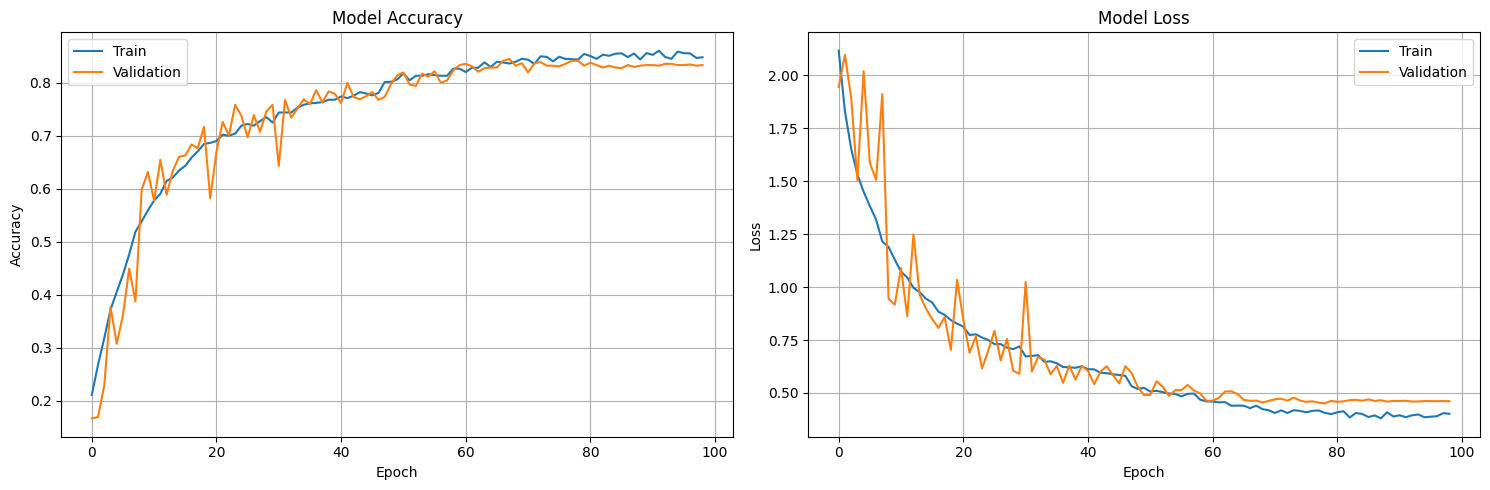

In [11]:
model, history, label_encoder = train_emotion_model(approach='custom')

Loading 15453 images...
Error loading Surprise/cropped_emotions.264999~12fffff.png: [Errno 2] No such file or directory: './data_emotion/Surprise/cropped_emotions.264999~12fffff.png'
Error loading Surprise/cropped_emotions.264140~12fffff.png: [Errno 2] No such file or directory: './data_emotion/Surprise/cropped_emotions.264140~12fffff.png'
Error loading Surprise/0a5baaa904a2a7fe93aab7ccf393a9180bc51354c073033b56b4b661~12fffff.jpg: [Errno 2] No such file or directory: './data_emotion/Surprise/0a5baaa904a2a7fe93aab7ccf393a9180bc51354c073033b56b4b661~12fffff.jpg'
Error loading Surprise/cropped_emotions.100222~12fffff.png: [Errno 2] No such file or directory: './data_emotion/Surprise/cropped_emotions.100222~12fffff.png'
Error loading Surprise/cropped_emotions.414867~12fffff.png: [Errno 2] No such file or directory: './data_emotion/Surprise/cropped_emotions.414867~12fffff.png'
Loaded 1000/15453 images
Loaded 3000/15453 images
Loaded 5000/15453 images
Loaded 6000/15453 images
Loaded 9000/154

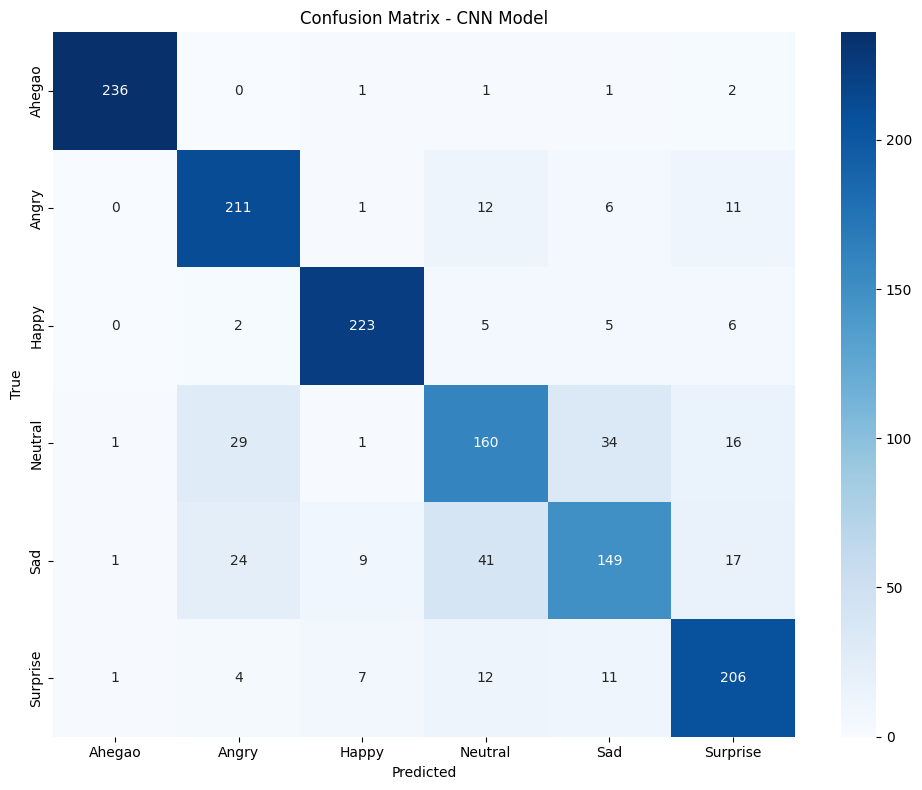

In [12]:


X, y = load_emotion_data('./data_emotion/data (1).csv', './data_emotion', target_size=(48, 48), grayscale=True)


y_encoded = label_encoder.transform(y)

_, X_test, _, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN Model')
plt.tight_layout()
plt.show()